In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numexpr as ne
import sys
from tqdm import tqdm
from sklearn.metrics import accuracy_score, log_loss

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../training_utils/')
from diagnostic_tools import top_k_accuracy, per_class_accuracy, count_params, entropy, model_calibration
from train_utils import train

In [3]:
import torch.cuda
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.benchmark = True

# Create iterators

In [5]:
data_dir = '/home/ubuntu/data/'
batch_size = 32

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

train_folder = ImageFolder(data_dir + 'train', transform)
val_folder = ImageFolder(data_dir + 'val', transform)

train_iterator = DataLoader(
    train_folder, batch_size=batch_size,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=64,
    shuffle=True, pin_memory=True
)

train_size = len(train_folder.imgs)
train_size

25600

# Model

In [7]:
from model_densenet import make_model

In [25]:
model, criterion, optimizer = make_model()

In [26]:
count_params(model)

7216256

# Train

In [27]:
n_epochs = 2
n_batches = int(np.ceil(train_size/batch_size))
M = 1
T = n_batches*n_epochs
initial = 0.01
n_batches

800

In [28]:
def lr_scheduler(optimizer, step):
    
    global initial
    decay = np.cos(np.pi*((step - 1) % (T // M))/(T // M)) + 1.0
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = initial*decay/2.0
    
    if (step - 1) % (T // M) == 0 and step != 1:
        # initial *= 0.1
        print('lr is reset:', initial)
        
    return optimizer

In [29]:
%%time
all_losses, all_models = train(
    model, criterion, optimizer, 
    train_iterator, n_epochs, n_batches, 
    val_iterator, validation_step=400, n_validation_batches=24, 
    saving_step=(T // M), lr_scheduler=lr_scheduler
)

0.50  2.422 1.176  0.568 0.756  0.749 0.912  149.178
1.00  1.066 0.901  0.806 0.816  0.943 0.943  149.095
1.50  0.801 0.864  0.877 0.831  0.971 0.954  149.211
2.00  0.764 0.845  0.895 0.831  0.977 0.951  149.287
saving
CPU times: user 31min 57s, sys: 2min, total: 33min 58s
Wall time: 9min 56s


# Loss/epoch

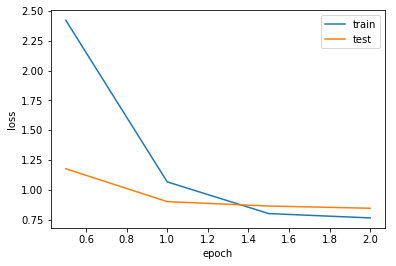

In [30]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='test');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

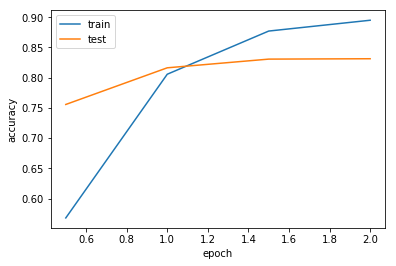

In [31]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='test');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

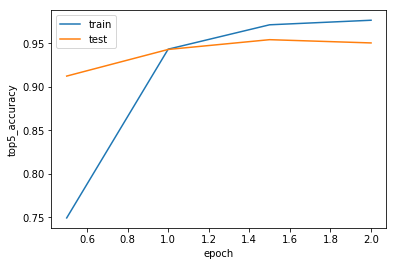

In [32]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='test');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Predict val. set

In [42]:
val_predictions = []
val_true = []

In [43]:
val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=64, shuffle=False, pin_memory=True
)

In [44]:
%%time
model.eval()

for x_batch, y_batch in tqdm(val_iterator_no_shuffle):

    x_batch = Variable(x_batch.cuda(), volatile=True)
    logits = model(x_batch)
    
    # compute probabilities
    probs = F.softmax(logits) 
    val_predictions += [probs.cpu().data.numpy()]
    
    val_true += [y_batch.numpy()]

100%|██████████| 80/80 [00:47<00:00,  1.66it/s]

CPU times: user 2min 4s, sys: 9.35 s, total: 2min 13s
Wall time: 47.8 s


In [45]:
val_predictions = np.concatenate(val_predictions, axis=0)
val_true = np.concatenate(val_true, axis=0)

In [46]:
accuracy_score(val_true, val_predictions.argmax(1))

0.82832031250000004

In [47]:
log_loss(val_true, val_predictions)

0.86752933369920771

In [48]:
top_k_accuracy(val_true, val_predictions, 2)

0.8984375

In [49]:
top_k_accuracy(val_true, val_predictions, 3)

0.92500000000000004

In [50]:
top_k_accuracy(val_true, val_predictions, 5)

0.94960937499999998

In [52]:
val_entropy = entropy(val_predictions)

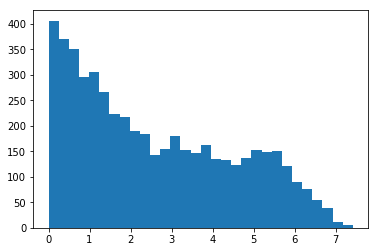

In [72]:
plt.hist(val_entropy, bins=30);

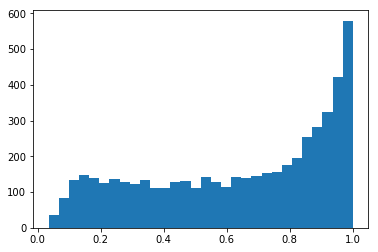

In [77]:
plt.hist(val_predictions.max(1), bins=30);

In [91]:
fraction_of_positives, mean_predicted_value = model_calibration(val_true, val_predictions, n_bins=10)

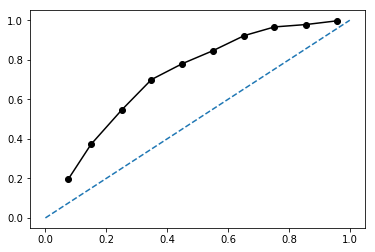

In [92]:
plt.plot(mean_predicted_value, fraction_of_positives, '-ok');
plt.plot([0.0, 1.0], [0.0, 1.0], '--');

In [78]:
per_class_acc = per_class_accuracy(val_true, val_predictions)
per_class_acc

array([ 0.9 ,  0.75,  1.  ,  0.95,  1.  ,  0.95,  0.95,  0.7 ,  0.95,
        0.9 ,  0.7 ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.9 ,  1.  ,
        0.7 ,  0.85,  0.85,  0.95,  0.85,  1.  ,  0.75,  1.  ,  0.6 ,
        0.95,  0.9 ,  0.65,  0.45,  1.  ,  0.95,  1.  ,  0.75,  0.95,
        0.75,  0.95,  0.95,  0.9 ,  0.35,  0.75,  0.95,  0.9 ,  0.9 ,
        0.95,  0.85,  0.85,  1.  ,  0.9 ,  0.45,  1.  ,  0.65,  0.7 ,
        0.5 ,  0.75,  0.95,  0.85,  1.  ,  0.9 ,  0.85,  0.9 ,  0.7 ,
        0.9 ,  1.  ,  0.95,  0.5 ,  0.6 ,  0.9 ,  0.95,  0.7 ,  0.3 ,
        1.  ,  0.7 ,  1.  ,  0.75,  1.  ,  0.9 ,  0.7 ,  0.9 ,  0.85,
        0.95,  0.35,  0.95,  0.7 ,  0.9 ,  0.9 ,  0.95,  0.85,  0.55,
        0.55,  0.85,  1.  ,  0.85,  0.95,  0.65,  1.  ,  0.95,  0.8 ,
        1.  ,  0.9 ,  0.9 ,  0.65,  0.95,  0.85,  0.7 ,  0.8 ,  0.9 ,
        0.5 ,  0.95,  0.65,  0.85,  0.95,  0.8 ,  1.  ,  0.85,  0.75,
        0.95,  0.8 ,  0.7 ,  0.8 ,  1.  ,  0.5 ,  0.8 ,  0.8 ,  0.5 ,
        0.9 ,  0.9 ,